In [3]:
import crepe
import numpy as np
import librosa
import matplotlib.pyplot as plt
import torch
import torchaudio

input, sr = librosa.load("audio-files/training-data/synth/synth.wav", sr=16000, mono=True)
input = input[:128000]

### F0 and Loudness non-torch ###

26/26 [==============================] - 3s 9ms/step
799


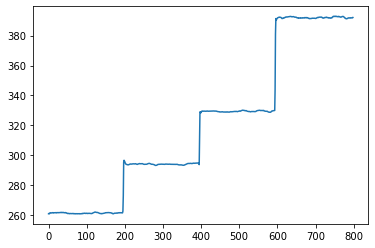

In [4]:
from encoders import Pitch_Extractor
import torch

block_size = 160

extract_f0 = Pitch_Extractor(sample_rate=sr, block_size=block_size)
pitch = extract_f0(torch.tensor(input))
print(len(pitch))
plt.plot(pitch)

1024


d:\Student projects\ML-AND\DDSP-Experiments\encoders.py:55: FutureWarning: Pass sr=16000, n_fft=2048 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  f = librosa.fft_frequencies(self.sample_rate, self.n_fft)
c:\Users\Me-Lab_Chimaera\anaconda3\lib\site-packages\librosa\core\convert.py:1332: RuntimeWarning: divide by zero encountered in log10
  + 2 * np.log10(f_sq)


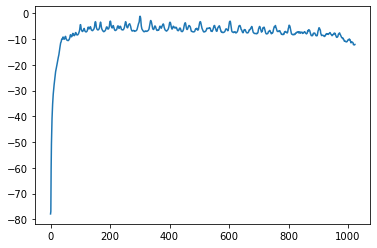

In [5]:
from encoders import Loudness_Extractor

n_fft = 2048

extract_vol = Loudness_Extractor(n_fft=2048, sample_rate=sr, block_size=block_size)
vol = extract_vol(torch.tensor(input))
print(len(vol))
plt.plot(vol)

### F0 and Loudness torch ###

In [7]:
from datasets.dataset_signal import Dataset
import torch
import yaml
from effortless_config import Config

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

sample_rate = config["preprocess"]["sample_rate"]

dataset = Dataset(config)
batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        shuffle=False,
                                        drop_last=False,
                                        )

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader)).size())

audio-files\training-data\synth\synth.wav:   0%|          | 0/1 [00:00<?, ?it/s]d:\Student projects\ML-AND\DDSP-Experiments\datasets\dataset_signal.py:12: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  x, sr = li.load(f, sample_rate, mono=True)
audio-files\training-data\synth\synth.wav: 100%|██████████| 1/1 [00:00<00:00,  5.55it/s]

Size of dataset: 2 
Size of sig batch: torch.Size([2, 64000])


In [8]:
class Torch_MFCC_Extractor(torch.nn.Module):
    def __init__(self, n_fft, sample_rate, block_size, device):
        super().__init__()
        self.n_fft = n_fft
        self.sample_rate = sample_rate
        self.block_size = block_size
        self.device = device

        self.mfcc = torchaudio.transforms.MFCC(sample_rate=sample_rate,
                                            n_mfcc=30,
                                            log_mels=True,
                                            melkwargs={"n_fft": self.n_fft, "hop_length": int(self.n_fft * (1 - 0.75)), 
                                            "center": True, "n_mels": 128, "f_min": 20.0, "f_max": 8000.0,}
                                            ).to(self.device)

    def forward(self, sig):
        length = sig.shape[-1] // int(self.n_fft * (1 - 0.75))
        mfccs = self.mfcc(sig)
        return mfccs[:, :, :length]




In [13]:
from datasets.dataset_all import Dataset, get_files
from effortless_config import Config
import yaml
import torch

#get_files("config.yaml")

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

dataset = Dataset(out_dir)

print(dataset[3]['pitches'].size())

batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=True,
)

print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader))['loudness'].size())

torch.Size([400])
Size of dataset: 81 
Size of sig batch: torch.Size([16, 64000]) 
Size of sig batch: torch.Size([16, 400]) 
Size of sig batch: torch.Size([16, 400])


In [14]:
import numpy as np

f1 = 554
f2 = 125
n = 12 * np.log2(f2/f1)
print(n)

pow(2, n/12) * f1

-25.775494576645215


124.99999999999999

In [15]:
pow(2, -12/12) * 261.63

130.815

In [18]:
from datasets.dataset_w_embedding import Dataset, get_files
from effortless_config import Config
import yaml
import torch

class args(Config):
    CONFIG = "config.yaml"

args.parse_args("")
with open(args.CONFIG, "r") as config:
    config = yaml.safe_load(config)

out_dir = config["preprocess"]["out_dir"]

#get_files("config.yaml")

dataset = Dataset(out_dir)

batch_size = config["hyperparams"]["batch_size"]
dataloader = torch.utils.data.DataLoader(dataset,
                                        batch_size,
                                        True,
                                        drop_last=False,
)


print("Size of dataset:", len(dataset), "\nSize of sig batch:", next(iter(dataloader))['signals'].size(), "\nSize of sig batch:", next(iter(dataloader))['pitches'].size(), "\nSize of sig batch:", next(iter(dataloader))['loudness'].size(), "\nSize of sig batch:", next(iter(dataloader))['embeddings'].size())

Size of dataset: 81 
Size of sig batch: torch.Size([16, 64000]) 
Size of sig batch: torch.Size([16, 400]) 
Size of sig batch: torch.Size([16, 400]) 
Size of sig batch: torch.Size([16, 256])
